In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import argparse
import pickle
pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pprint import pprint

plt.style.use('ggplot')
plt.figure(figsize=(12,8), dpi= 100)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

start_date = '2018-11-26' # the datasets start from this date
split_date = '2021-02-25' # the date for train test split
test_start = start_date # the start date for the testset. this is
                          # in case we want a longer testing period
                          # than the train test split
test_end = (datetime.strptime(split_date, '%Y-%m-%d').date()+timedelta(180)).strftime('%Y-%m-%d') # portfolio valid for 180 days

# coin prices to use to impute missing data
pred_coins = ["bitcoin", "ethereum", "tether", "usd-coin"] 

<Figure size 1200x800 with 0 Axes>

## Preprocessing
### Lending Data

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

data_dir = "../data/lending_data/"
skip_files = {"maker.csv", "aave.csv"}
datasets = [str(f) for f in listdir(data_dir) if isfile(join(data_dir, 
                                                             f)) and str(f) not in skip_files]
lend_protocol_dfs = {dataset[:-4] : pd.read_csv(data_dir+dataset, index_col=0)  for dataset in datasets}    

def impute_data(X, y, start_date=start_date, end_date=split_date):
    """
    impute the data for asset y using btc, eth and stable coin prices
    """
    start_date_dt = datetime.strptime(start_date,"%Y-%m-%d").date()
    end_date_dt = datetime.strptime(end_date,"%Y-%m-%d").date()
    
    X_train_start_idx = (y.index[0] - X.index[0]).days
    X_train_end_idx = (end_date_dt - X.index[0]).days
    y_train_end_idx = (end_date_dt - y.index[0]).days
    impute_start_idx = (start_date_dt - X.index[0]).days
    
    if X_train_start_idx >= X_train_end_idx:
        X_train_end_idx = (datetime.strptime('2021-03-25',"%Y-%m-%d").date() - X.index[0]).days
        y_train_end_idx = (datetime.strptime('2021-03-25',"%Y-%m-%d").date() - y.index[0]).days
    assert X_train_end_idx >= 0
    assert y_train_end_idx >= 0, f"{y.index[0]}, {X.index[0]}, {y_train_end_idx}"
    assert impute_start_idx >= 0, f"{start_date_dt}, {X.index[0]}"
    

    X_train = X[X_train_start_idx:X_train_end_idx]
    X_test = X[impute_start_idx:X_train_start_idx]
    y_train = y[:y_train_end_idx].to_numpy().reshape((y_train_end_idx,))
     
    if impute_start_idx < X_train_start_idx:
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_index = X.index[impute_start_idx:X_train_start_idx]
        df_y_pred = pd.DataFrame(y_pred.reshape((-1, 1)), index=y_pred_index, columns=y.columns)
        return df_y_pred.append(y)
    else:
        return y
    
def merge_dfs(dfs, return_col, rolling_mean=False): 
    """
    merge return cols of dfs based on index column. take rolling
    mean of 7 days and return the resulting df
    """
    merged_df = None
    for name, df in dfs.items():
        df = df.rename(columns={f"{return_col}": name})[[name]]
        merged_df = (
            df if merged_df is None
            else pd.merge(merged_df, df, left_index=True, right_index=True, how="inner")
        )
    if rolling_mean:
        merged_df = merged_df.rolling(7, min_periods=1).mean()
    return merged_df

for protocol, df in lend_protocol_dfs.items():
    x_values = [datetime.strptime(d,"%Y-%m-%d").date() for d in df.index]
    df.index = x_values
    # reverse the dataframe so that most recent data is at the tail
    lend_protocol_dfs[protocol] = df.iloc[::-1]
    print(protocol, min(x_values))

print("\n==compound==")
lend_protocol_dfs["compound"].head()

compound 2019-07-17
c_r_e_a_m_-finance 2020-08-25
definer 2020-11-03
dydx 2019-05-09

==compound==


,lend_rate,borrow_rate
2019-07-17,9.953725,13.775127
2019-07-18,11.207770,14.420475
2019-07-19,11.045261,14.384209
2019-07-20,13.987419,17.229919
2019-07-21,12.805582,16.663595


## Coin data

In [3]:
data_dir = "../data/coin_data/"
exclude = {'markets.csv', 'maker.csv'}
coin_start_date = datetime.strptime(start_date,"%Y-%m-%d").date()
datasets = [str(f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and str(f) not in exclude]
coin_dfs = {dataset[:-4] : pd.read_csv(data_dir+dataset, index_col=2)  for dataset in datasets}

print("coin name\tdata start")
for k in list(coin_dfs.keys()):
    df = coin_dfs[k]
    try: 
        x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S.%f").date() for d in df.index]
    except ValueError:
        x_values = [datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in df.index]
    df.index = x_values
    if min(x_values) > coin_start_date or k in exclude:
        del coin_dfs[k]
    else:
        print(k, min(x_values), sep="\t")
    df.drop(columns=['timestamp'], inplace=True)

coin_df = merge_dfs(coin_dfs, 'price', rolling_mean=True)
# rearrange the columns
coin_df_cols = ['bitcoin', 'ethereum', 'binancecoin', 'bitcoin-cash-sv', 'bitcoin-cash', 'cardano',
       'celsius-degree-token', 'chainlink', 'decred', 'dogecoin', 'eos',
       'ethereum-classic', 'huobi-token', 'iota', 'litecoin',
       'monero', 'neo', 'okb', 'ripple', 'stellar', 'tether', 'tezos',
       'theta-token', 'tron', 'usd-coin', 'vechain']

coin_df = coin_df[coin_df_cols]

coin name	data start
binancecoin	2017-09-16
bitcoin-cash-sv	2018-11-10
bitcoin-cash	2017-08-02
bitcoin	2013-04-28
cardano	2017-10-18
celsius-degree-token	2018-10-12
chainlink	2017-11-09
decred	2016-02-10
dogecoin	2013-12-15
eos	2017-07-09
ethereum-classic	2016-07-24
ethereum	2015-08-07
huobi-token	2018-02-09
iota	2017-06-14
litecoin	2013-04-28
monero	2014-05-21
neo	2016-09-09
okb	2018-06-07
ripple	2013-08-04
stellar	2014-08-06
tether	2015-02-25
tezos	2018-07-03
theta-token	2018-01-24
tron	2017-11-09
usd-coin	2018-10-05
vechain	2018-07-27


## Plotting

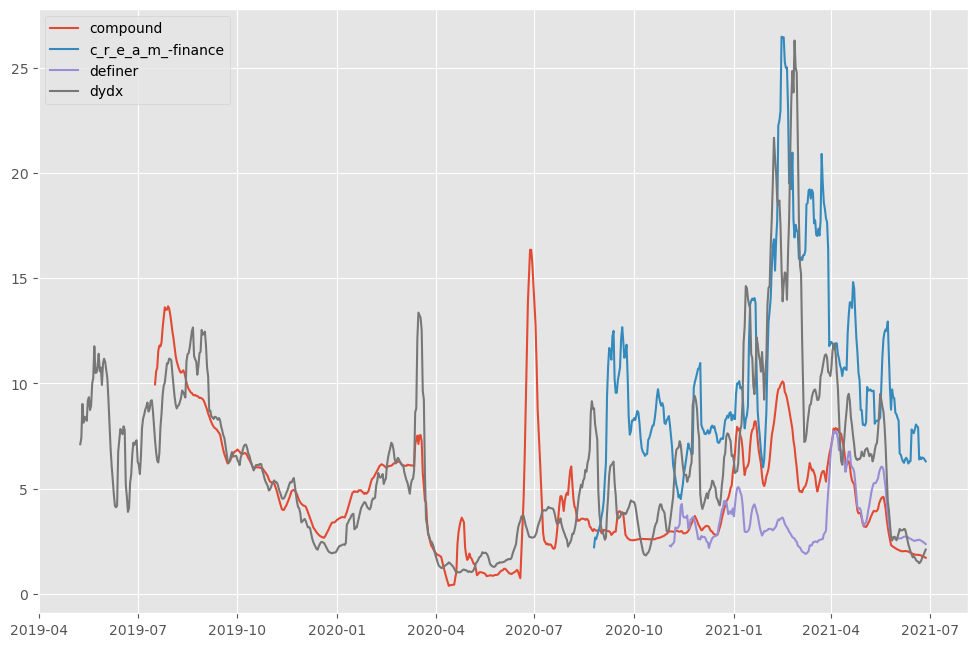

In [4]:
for k, df in lend_protocol_dfs.items():
    x_values = df.index
    y_values = df["lend_rate"].rolling(7, min_periods=1).mean()
    plt.plot(x_values, y_values, '-', label=k)
plt.legend()
plt.show()

R2 0.5243931111974656


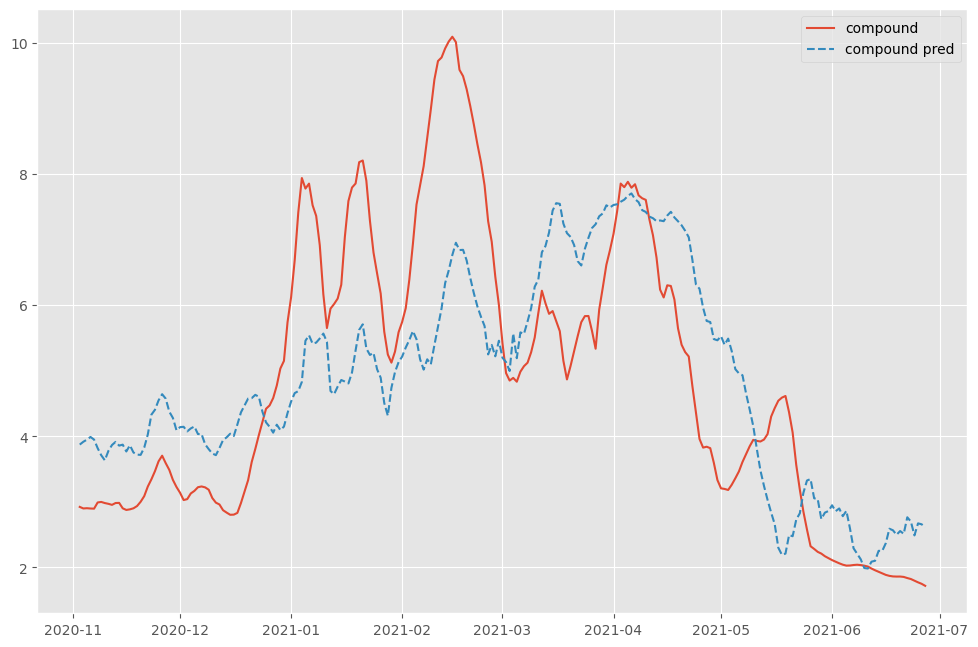

R2 0.49278592406092836


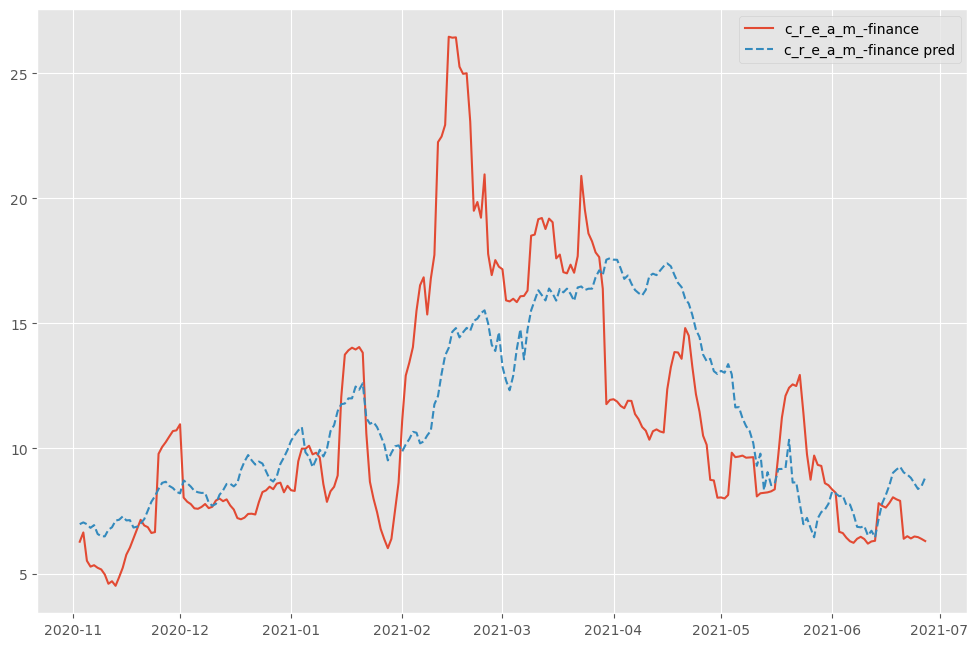

R2 0.3458659813291932


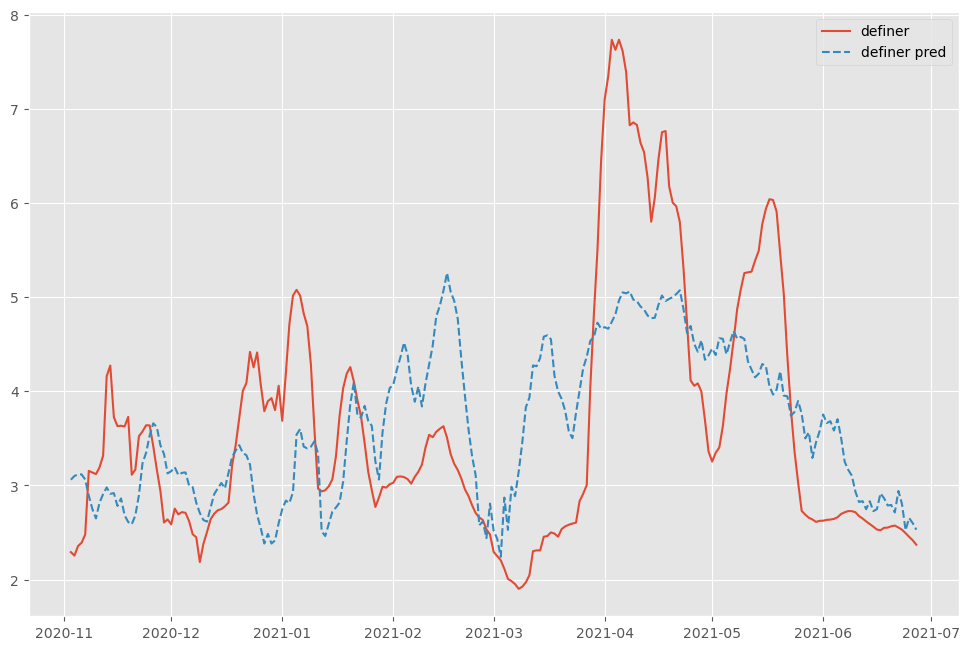

R2 0.31567741065830157


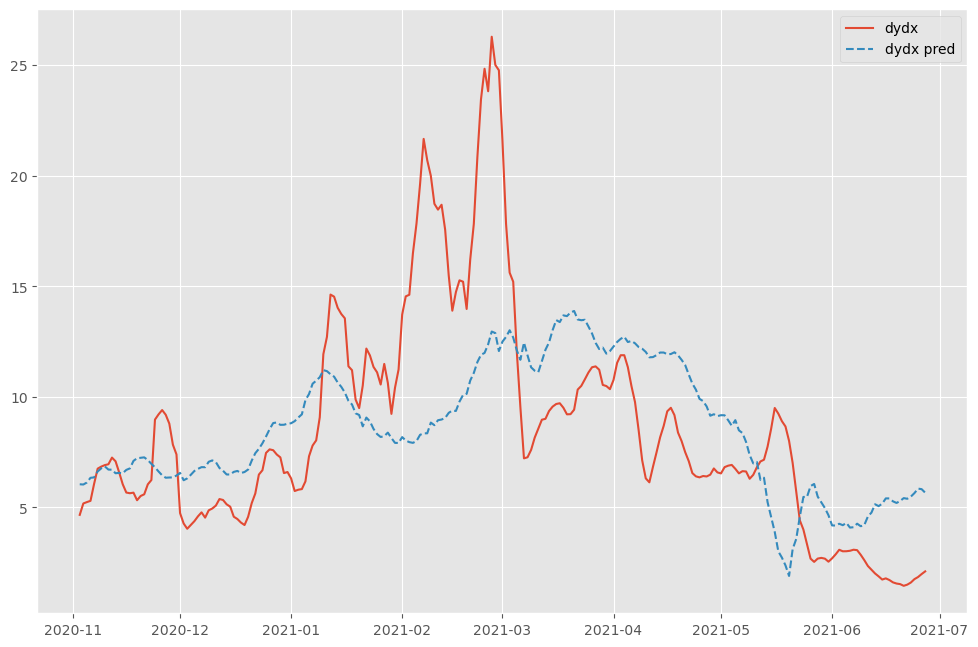

<AxesSubplot:>

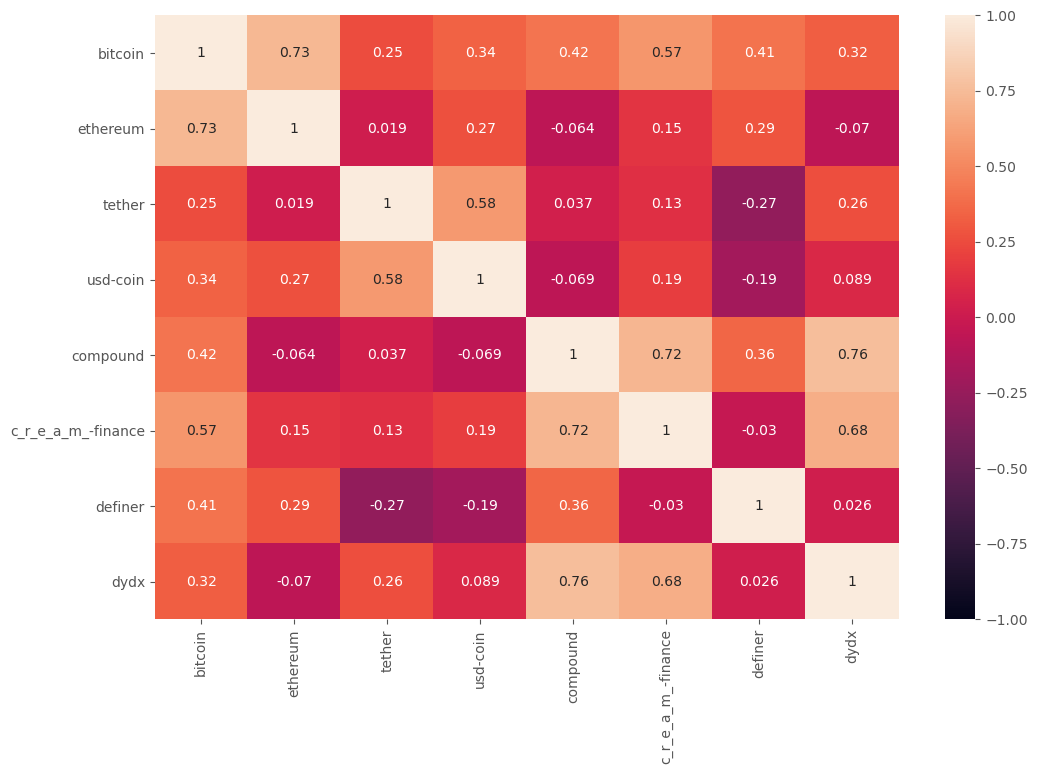

In [5]:
from sklearn.linear_model import LinearRegression

lend_rates_df = merge_dfs(lend_protocol_dfs, "lend_rate", rolling_mean=True)
lend_rates_df = pd.merge(coin_df[pred_coins], lend_rates_df, 
                     left_index=True, right_index=True, how="inner")

for protocol in lend_rates_df.columns:
    if protocol in set(pred_coins):
        continue
    X = lend_rates_df[pred_coins]
    y = lend_rates_df[protocol]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    print("R2", r2_score(y, y_pred))
    plt.plot(lend_rates_df.index, y, '-', label=protocol)
    plt.plot(lend_rates_df.index, y_pred, '--', label=f"{protocol} pred")
    plt.legend()
    plt.show()
sns.heatmap(lend_rates_df.corr(), vmin=-1, vmax=1, annot=True)

In [6]:
# impute data
for protocol in lend_protocol_dfs.keys():
    X = coin_df[pred_coins]
    y = lend_protocol_dfs[protocol][["lend_rate"]]
    lend_protocol_dfs[protocol] = impute_data(X, y)

lend_rates_df = merge_dfs(lend_protocol_dfs, "lend_rate", rolling_mean=True)
lend_rates_df["nexo"] = 12.0 # usdc, usdt
lend_rates_df["celsius"] = 8.8 # usdc, usdt
lend_rates_df.head(10)

,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2018-11-26,17.454521,18.300400,3.913578,10.633747,12.0,8.8
2018-11-27,17.376886,18.214152,3.893973,10.606367,12.0,8.8
2018-11-28,17.247727,18.078100,3.840672,10.637696,12.0,8.8
2018-11-29,16.959025,17.822206,3.799252,10.522787,12.0,8.8
2018-11-30,16.378359,17.325832,3.742631,10.235984,12.0,8.8
2018-12-01,15.911635,16.930640,3.700654,9.994421,12.0,8.8
2018-12-02,15.473289,16.548177,3.642122,9.822307,12.0,8.8
2018-12-03,14.675240,15.857619,3.552554,9.457406,12.0,8.8
2018-12-04,13.803819,15.104639,3.448387,9.083978,12.0,8.8
2018-12-05,12.911564,14.333779,3.343962,8.700040,12.0,8.8


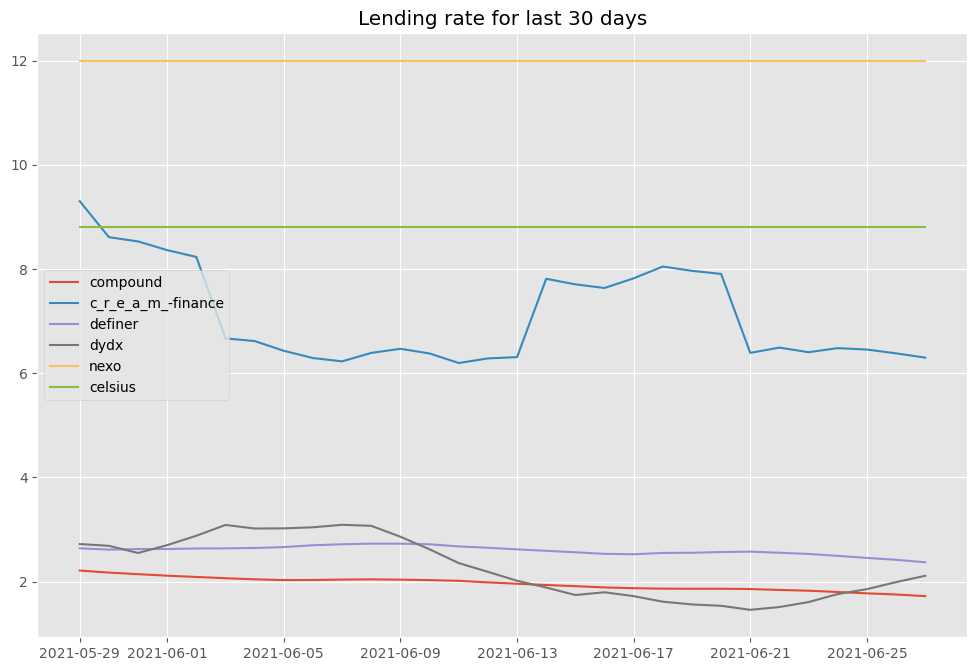

In [7]:
temp_df = lend_rates_df.tail(30)
for col in temp_df.columns:
    y_values = temp_df[col]    
    plt.plot(temp_df.index, y_values, '-', label=col)
plt.legend()
plt.title("Lending rate for last 30 days")
plt.show()

lending rates: 7 days rolling avg


<AxesSubplot:>

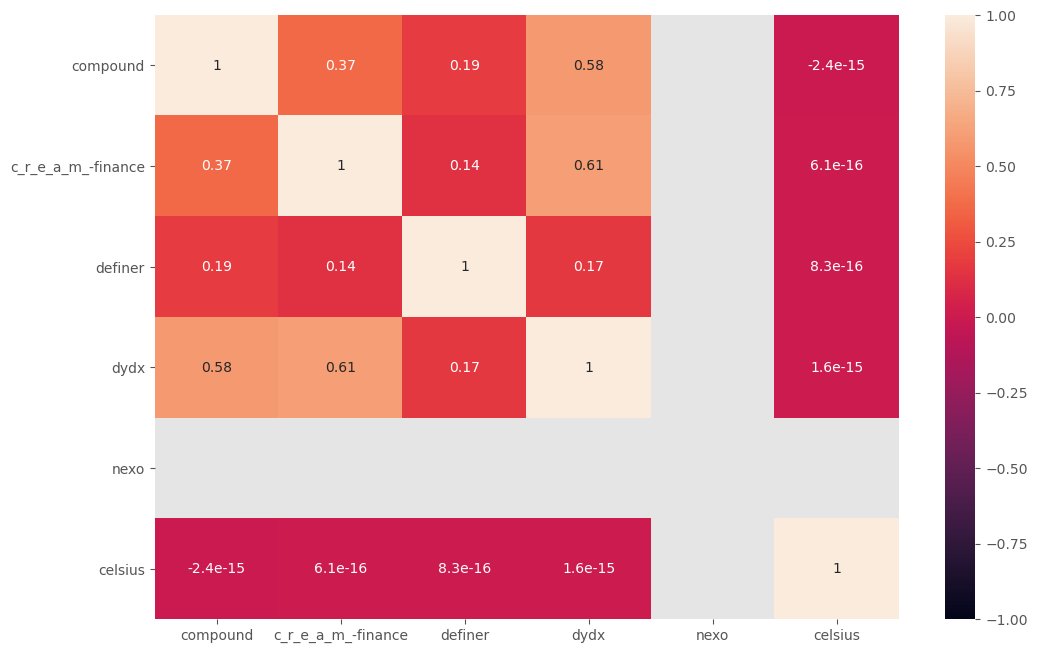

In [8]:
print("lending rates: 7 days rolling avg")
sns.heatmap(lend_rates_df.corr(), vmin=-1, vmax=1, annot=True)

lending rates: 7 days rolling avg for last 30 days


<AxesSubplot:>

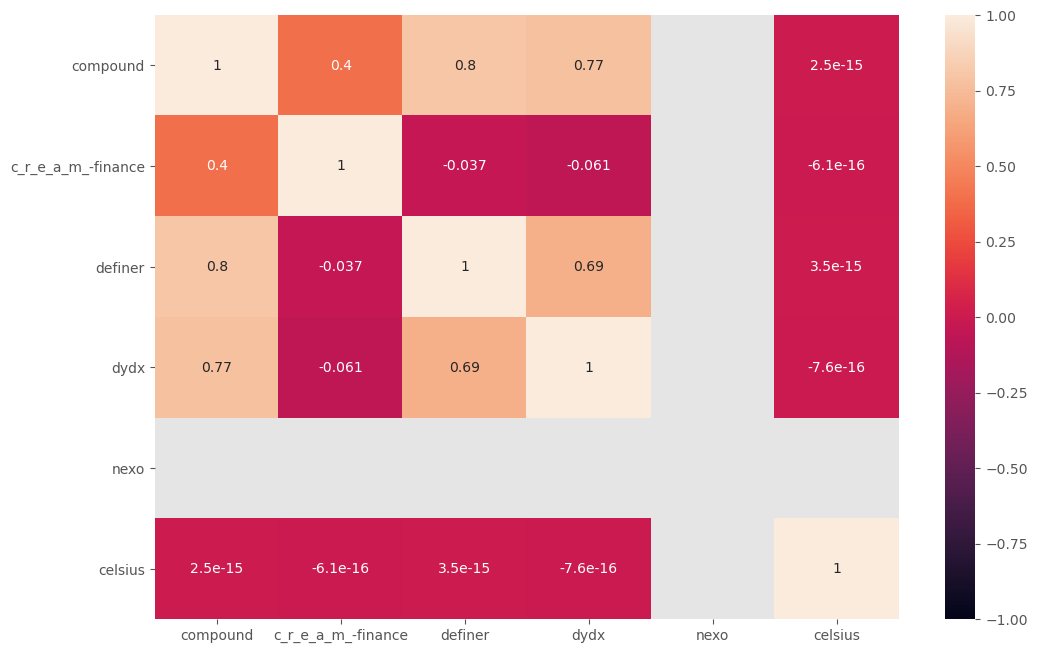

In [9]:
print("lending rates: 7 days rolling avg for last 30 days")
sns.heatmap(lend_rates_df.tail(30).corr(), vmin=-1, vmax=1, annot=True)

In [10]:
lend_rates_df.std()

compound              3.063258e+00
c_r_e_a_m_-finance    3.634716e+00
definer               8.148871e-01
dydx                  3.782991e+00
nexo                  0.000000e+00
celsius               1.155244e-13
dtype: float64

In [11]:
# start with $1, and apply daily yield each day to convert
# lend rates to lending protocol (lp) returns
lp_returns = {market : [1] for market in lend_rates_df.columns}
for i, date in enumerate(lend_rates_df.index):
    if i == len(lend_rates_df.index) - 1:
        continue
    for market, returns in lp_returns.items():
        daily_yield = (1+lend_rates_df[market][i]/100)**(1/365)-1
        returns.append(returns[-1]*(1+daily_yield))   
lp_returns_df = pd.DataFrame(lp_returns, index=lend_rates_df.index)
lp_returns_df.head(10)

,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2018-11-26,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-11-27,1.000441,1.000461,1.000105,1.000277,1.000311,1.000231
2018-11-28,1.000880,1.000919,1.000210,1.000553,1.000621,1.000462
2018-11-29,1.001317,1.001375,1.000313,1.000830,1.000932,1.000693
2018-11-30,1.001746,1.001825,1.000415,1.001105,1.001243,1.000925
2018-12-01,1.002163,1.002264,1.000516,1.001372,1.001554,1.001156
2018-12-02,1.002568,1.002693,1.000616,1.001633,1.001865,1.001387
2018-12-03,1.002963,1.003114,1.000714,1.001891,1.002176,1.001619
2018-12-04,1.003340,1.003519,1.000809,1.002139,1.002487,1.001850
2018-12-05,1.003695,1.003906,1.000902,1.002377,1.002798,1.002082


In [12]:
lp_returns_df.tail(10)

,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2021-06-18,1.137316,1.220685,1.081338,1.163246,1.336424,1.240880
2021-06-19,1.137373,1.220944,1.081413,1.163297,1.336839,1.241167
2021-06-20,1.137431,1.221200,1.081487,1.163347,1.337254,1.241454
2021-06-21,1.137488,1.221455,1.081562,1.163395,1.337669,1.241741
2021-06-22,1.137546,1.221662,1.081638,1.163441,1.338085,1.242028
2021-06-23,1.137602,1.221872,1.081712,1.163489,1.338500,1.242315
2021-06-24,1.137659,1.222080,1.081786,1.163540,1.338916,1.242602
2021-06-25,1.137714,1.222290,1.081859,1.163595,1.339332,1.242889
2021-06-26,1.137769,1.222500,1.081931,1.163654,1.339747,1.243176
2021-06-27,1.137823,1.222707,1.082002,1.163717,1.340164,1.243463


## Coin Correlations

coin price in last 15 months: 7 days rolling avg


<AxesSubplot:>

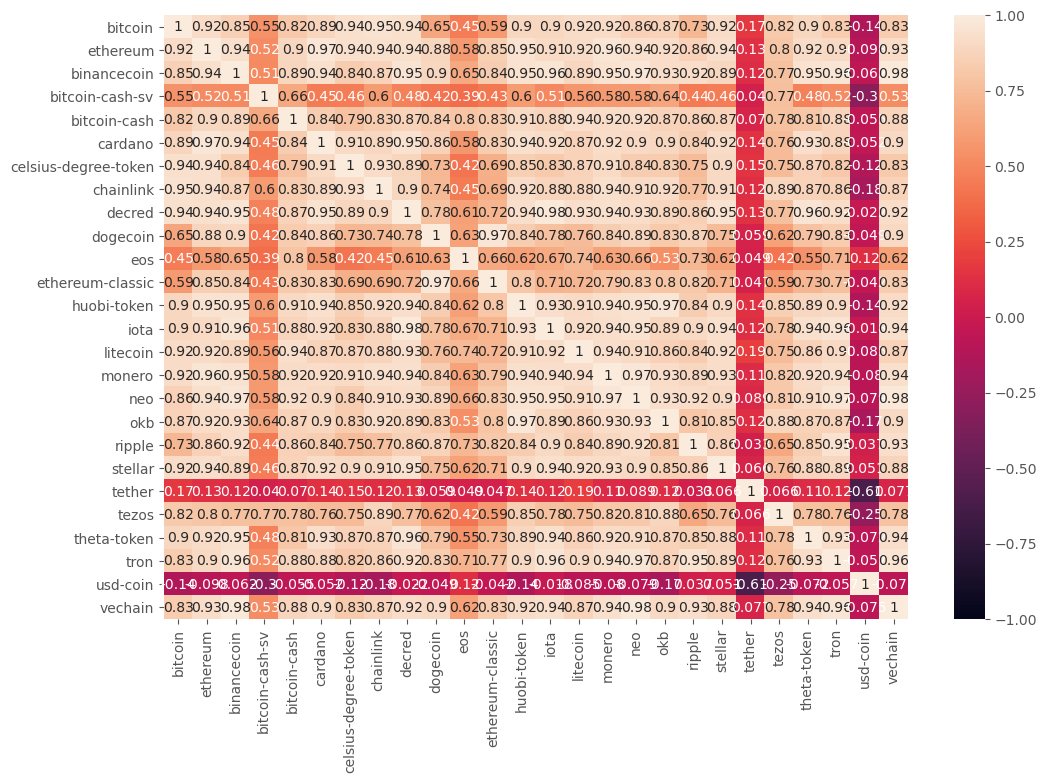

In [13]:
print("coin price in last 15 months: 7 days rolling avg")
sns.heatmap(coin_df.corr(), vmin=-1, vmax=1, annot=True)

coin price in last 15 months: 7 days rolling avg


Text(0.5, 1.0, 'Nov 07 2020 - Apr 07 2020')

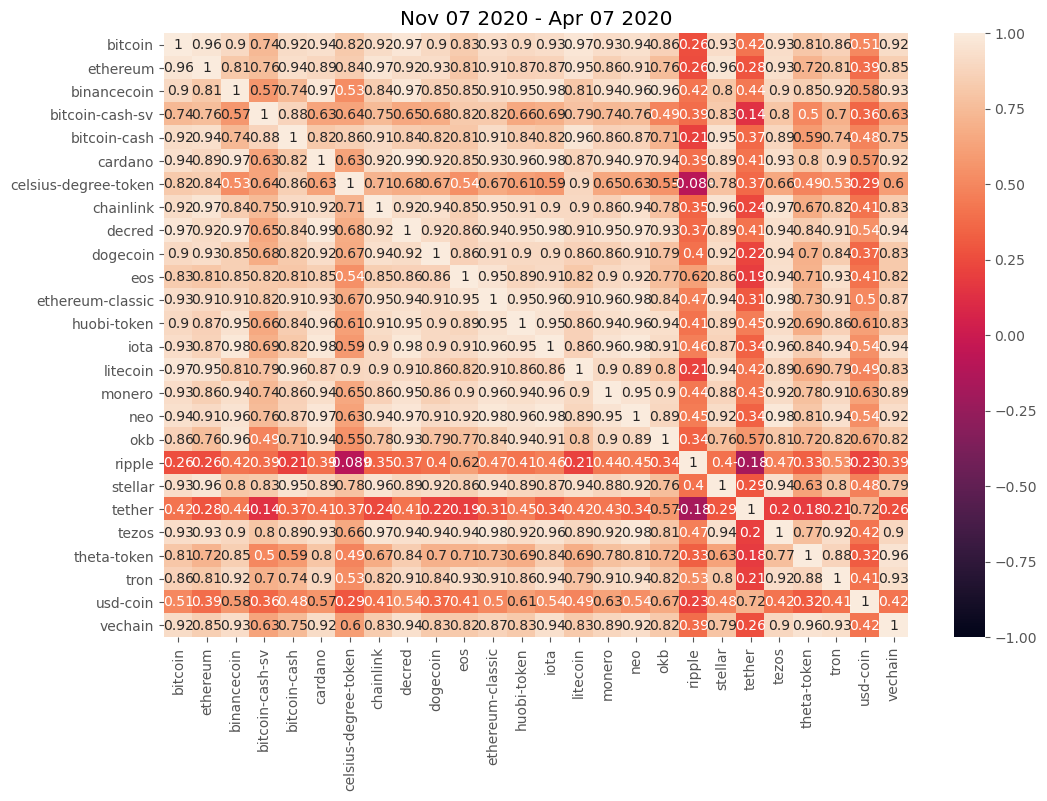

In [14]:
print("coin price in last 15 months: 7 days rolling avg")
temp_df = coin_df[(coin_df.index > datetime.strptime('2020-11-07', '%Y-%m-%d').date()
                  ) & (coin_df.index < datetime.strptime('2021-04-07', '%Y-%m-%d').date())]
temp_df
sns.heatmap(temp_df.corr(), vmin=-1, vmax=1, annot=True)
plt.title("Nov 07 2020 - Apr 07 2020")

In [15]:
# dividing by the mean because the coin prices are not on the same scale. 
# This is the relative volatility of various coins
coin_df_cols = ['bitcoin', 'ethereum', 'binancecoin', 'cardano', 'ripple', 'dogecoin', 'bitcoin-cash', 
       'litecoin', 'chainlink', 'ethereum-classic']
coin_df = coin_df[coin_df_cols]
(coin_df/coin_df.mean()).std()

bitcoin             0.983577
ethereum            1.358960
binancecoin         1.890341
cardano             1.738975
ripple              0.717316
dogecoin            2.870836
bitcoin-cash        0.592864
litecoin            0.729989
chainlink           1.245500
ethereum-classic    1.497275
dtype: float64

## Portfolio Optimization
1: lowest risk, 5 highest risk: 5
### Risk 1: Only lending protocols

In [16]:
def generate_roi(asset_weights, assets_df, plot=True, rebalance_period=1):
    """
    given the asset weights, generate the return on $100 initial investment
    rebalances on the first day of each rebalance_period
    """
    investment_total = 100
    asset_allocation = {
        asset: investment_total * weight for asset, weight in asset_weights.items()
    }
    investment_daily_value = [investment_total]
    for i in range(len(assets_df) - 1):
        for asset, weight in asset_weights.items():
            asset_price_today = assets_df[asset][i]
            asset_price_next_day = assets_df[asset][i + 1]
            asset_allocation[asset] *= asset_price_next_day / asset_price_today
        investment_total = sum(asset_allocation.values())
        investment_daily_value.append(investment_total)
        if i % rebalance_period == 0:
            asset_allocation = {
                asset: investment_total * weight for asset, weight in asset_weights.items()
            }

    roi = [dv - 100 for dv in investment_daily_value]
    if plot:
        plt.plot(assets_df.index, roi, "--", label="portfolio")
        plt.annotate(text="portfolio", xy=(assets_df.index[-1], roi[-1]), fontsize=8)
        for asset in assets_df.columns:
            roi_asset = (assets_df[asset] / assets_df[asset][0]) * 100 - 100
            x, y = assets_df.index, roi_asset
            plt.plot(x, y, label=asset)
            plt.annotate(text=asset, xy=(x[-1], y[-1]), fontsize=8)
            plt.ylabel("apy %")
    #             plt.legend()
    return roi


def evaluation(weights, assets_df, rebalance_period=1):
    # expected return
    mu = mean_historical_return(assets_df, frequency=365)
    # covariance matrix
    S = risk_matrix(assets_df, method='ledoit_wolf', frequency=365)
    _ = portfolio_performance(
        weights, mu, S, verbose=True, risk_free_rate=0.02
    )
    roi = generate_roi(weights, assets_df, plot=True, rebalance_period=rebalance_period)
    return roi
    

    
def optimize_portfolio(train_df, test_df, rebalance_period, target_volatility, constraints_fn):
    # expected return
    mu = mean_historical_return(train_df, frequency=365)
    # covariance matrix
    S = risk_matrix(train_df, method='ledoit_wolf', frequency=365)
    print("mean (yearly) return:")
    print(mu)
    ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
    # add the constraints
    constraints_fn(ef, train_df)
    weights = ef.efficient_risk(target_volatility=target_volatility)
    print("\n---portfolio weights---")
    pprint(ef.clean_weights())
    print("\n")
    _ = evaluation(weights, train_df, rebalance_period=rebalance_period)
    plt.title("Training set performance")
    plt.show()
    roi = evaluation(weights, test_df)
    plt.title(f"APY vs time. Test period: {split_date}-{test_end}")
    plt.show()
    print("return in the test period", roi[-1])
    return ef.clean_weights(), roi    

mean (yearly) return:
compound              0.052304
c_r_e_a_m_-finance    0.075553
definer               0.029790
dydx                  0.058097
nexo                  0.120000
celsius               0.088000
dtype: float64

---portfolio weights---
OrderedDict([('compound', 0.0),
             ('c_r_e_a_m_-finance', 0.3),
             ('definer', 0.0),
             ('dydx', 0.1),
             ('nexo', 0.3),
             ('celsius', 0.3)])


Expected annual return: 9.1%
Annual volatility: 0.1%
Sharpe Ratio: 126.08


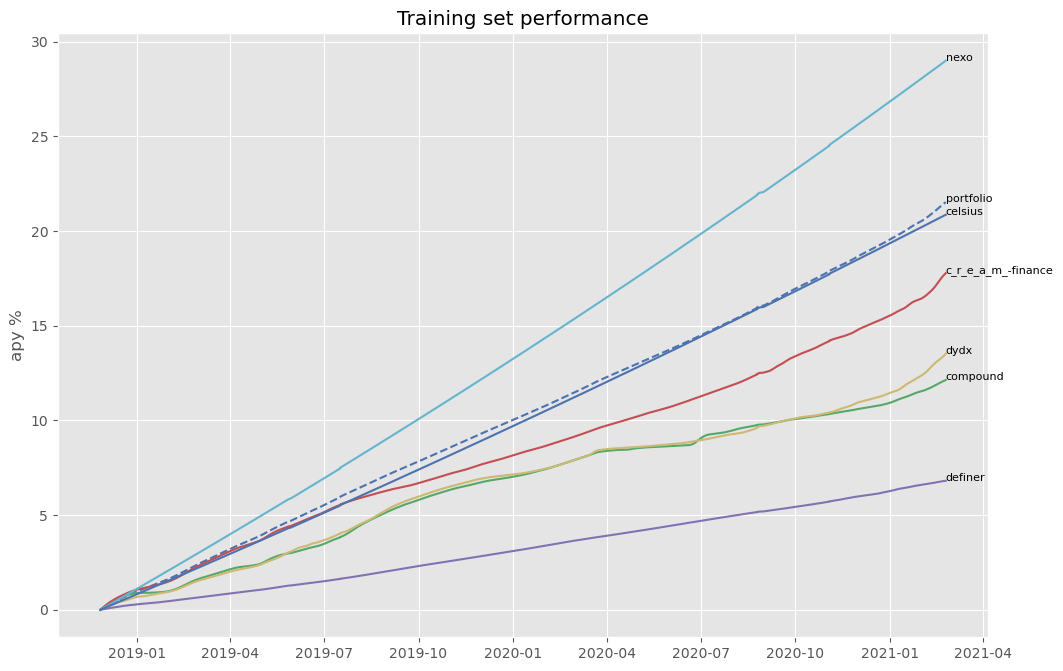

Expected annual return: 9.3%
Annual volatility: 0.1%
Sharpe Ratio: 114.03


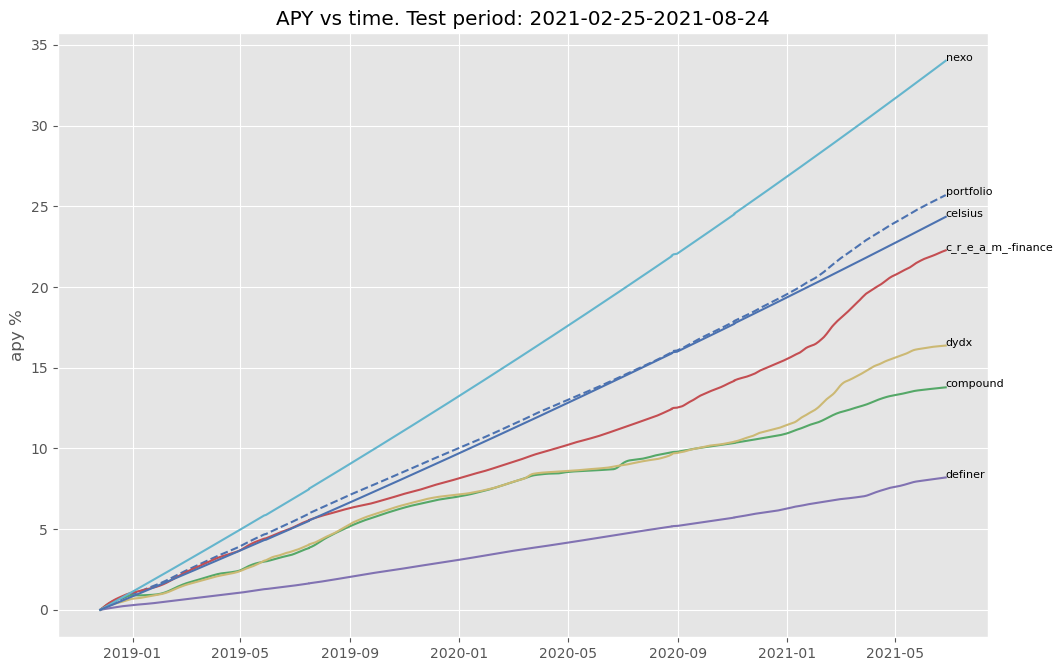

return in the test period 25.695469955322267


In [17]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
from pypfopt.base_optimizer import portfolio_performance

train_df = lp_returns_df[lp_returns_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = lp_returns_df[(lp_returns_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (lp_returns_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]
def risk1_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] <= 0.3)

risk1_weights, risk1_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=1, 
                                   target_volatility=0.05, 
                                   constraints_fn=risk1_constraints)

## Risk 2 Portfolio
Lending protocols and BTC and ETH with 10% target volatility


mean (yearly) return:
bitcoin               2.059573
ethereum              2.278257
compound              0.052304
c_r_e_a_m_-finance    0.075553
definer               0.029790
dydx                  0.058097
nexo                  0.120000
celsius               0.088000
dtype: float64

---portfolio weights---
OrderedDict([('bitcoin', 0.3),
             ('ethereum', 0.0522),
             ('compound', 0.0),
             ('c_r_e_a_m_-finance', 0.0478),
             ('definer', 0.0),
             ('dydx', 0.0),
             ('nexo', 0.3),
             ('celsius', 0.3)])


Expected annual return: 80.3%
Annual volatility: 10.0%
Sharpe Ratio: 7.83


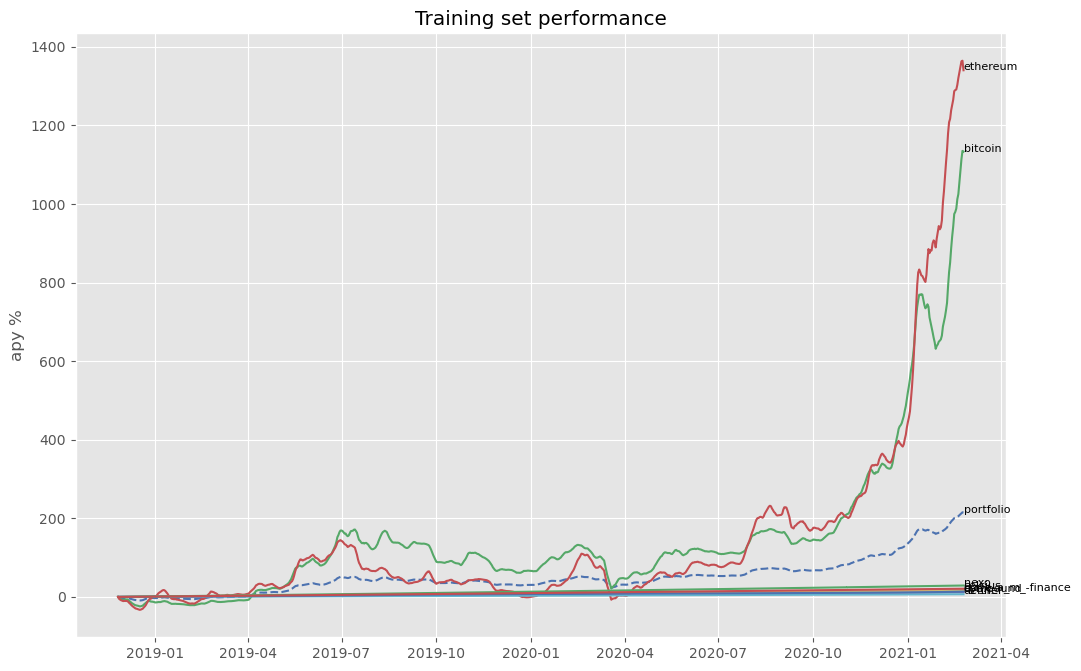

Expected annual return: 52.1%
Annual volatility: 10.3%
Sharpe Ratio: 4.89


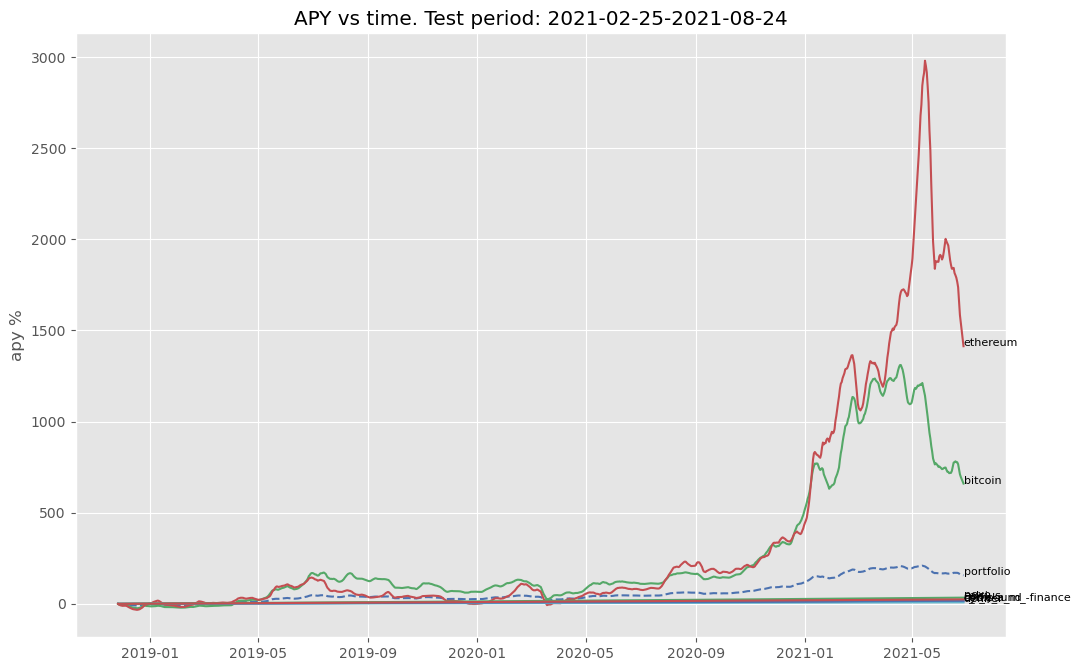

return in the test period 156.42272547241453


In [18]:
# merge coin and lp datasets
assets_df = pd.merge(coin_df[["bitcoin", "ethereum"]], lp_returns_df, 
                     left_index=True, right_index=True, how="inner")
# split data into train and test
train_df = assets_df[assets_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = assets_df[(assets_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (assets_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

def risk2_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] <= 0.3)
    
#     ef.add_constraint(lambda w: w[0]+w[1] <= 0.10)
    # keep some bitcoin, but not too much
    ef.add_constraint(lambda w: w[0] >= 0.02)
    # keep some ethereum
    ef.add_constraint(lambda w: w[1] >= 0.02)


risk2_weights, risk2_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=7, 
                                   target_volatility=0.10, 
                                   constraints_fn=risk2_constraints)

## Risk 3 Portfolio
Lending protocols and BTC and ETH with 20% target volatility


mean (yearly) return:
bitcoin               2.059573
ethereum              2.278257
compound              0.052304
c_r_e_a_m_-finance    0.075553
definer               0.029790
dydx                  0.058097
nexo                  0.120000
celsius               0.088000
dtype: float64

---portfolio weights---
OrderedDict([('bitcoin', 0.3),
             ('ethereum', 0.20453),
             ('compound', 0.0),
             ('c_r_e_a_m_-finance', 0.0),
             ('definer', 0.0),
             ('dydx', 0.0),
             ('nexo', 0.3),
             ('celsius', 0.19547)])


Expected annual return: 113.7%
Annual volatility: 15.0%
Sharpe Ratio: 7.45


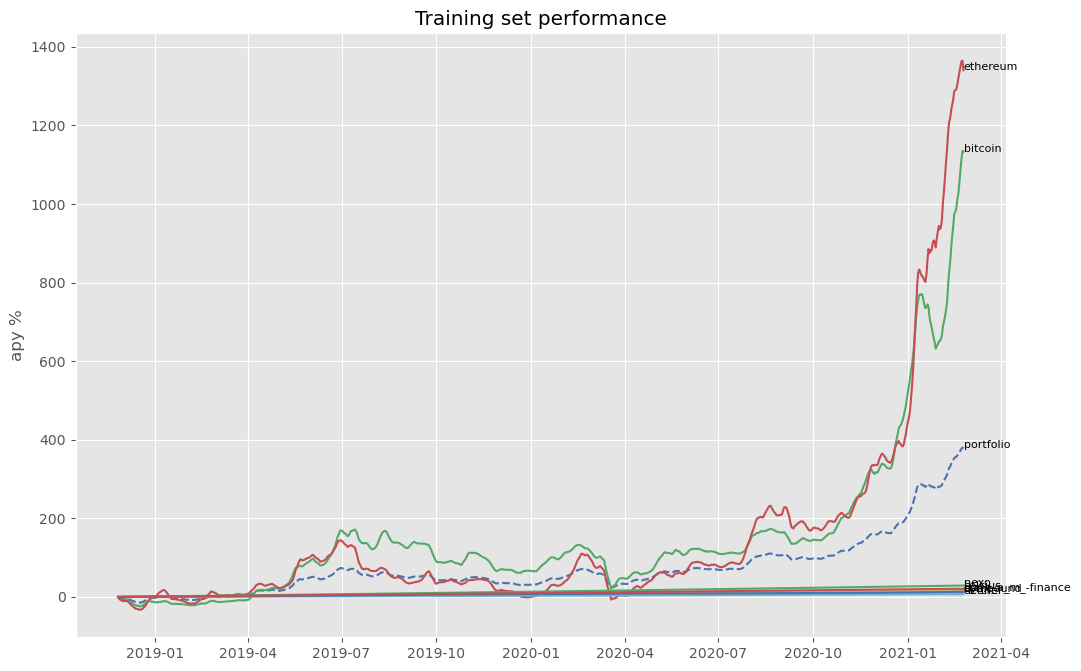

Expected annual return: 79.2%
Annual volatility: 15.4%
Sharpe Ratio: 5.00


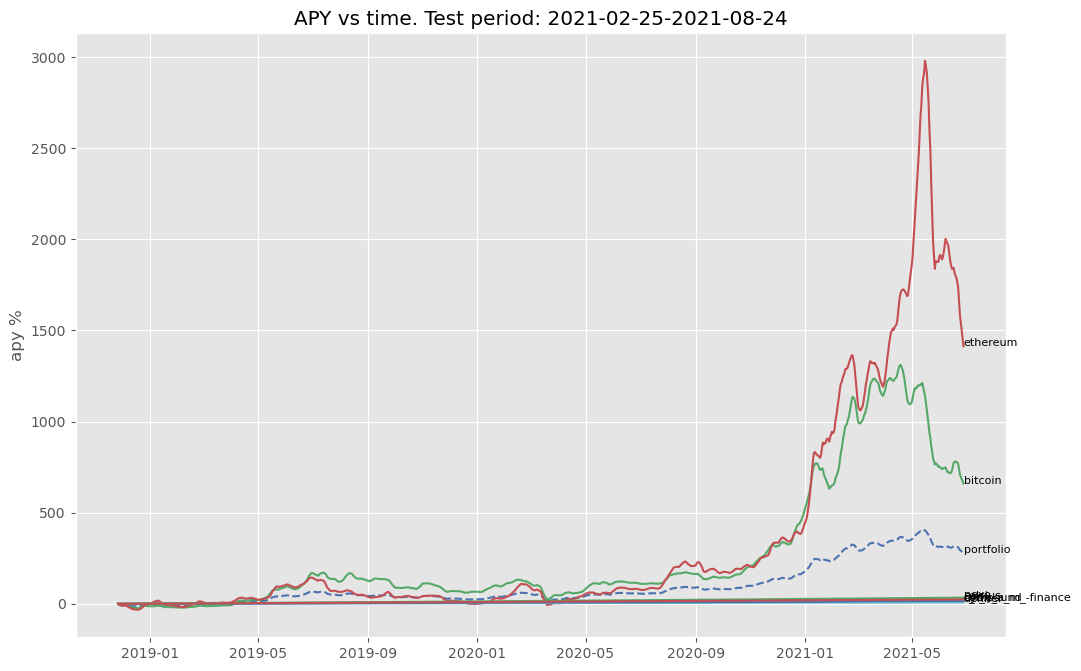

return in the test period 279.5978957957809


In [19]:
# merge coin and lp datasets
assets_df = pd.merge(coin_df[["bitcoin", "ethereum"]], lp_returns_df, 
                     left_index=True, right_index=True, how="inner")
# split data into train and test
train_df = assets_df[assets_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = assets_df[(assets_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (assets_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

def risk3_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] <= 0.3)
    
#   ef.add_constraint(lambda w: w[0]+w[1] <= 0.20)
    # keep some bitcoin, but not too much
    ef.add_constraint(lambda w: w[0] >= 0.02)
    # keep some ethereum
    ef.add_constraint(lambda w: w[1] >= 0.02)


risk3_weights, risk3_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=7, 
                                   target_volatility=0.15, 
                                   constraints_fn=risk3_constraints)

## Risk 4 Portfolio
Lending protocols, BTC, ETH, BNB, ADA, XRP with 30% target volatility

mean (yearly) return:
bitcoin               2.059573
ethereum              2.278257
binancecoin           4.342222
cardano               3.002577
ripple                0.111870
compound              0.052304
c_r_e_a_m_-finance    0.075553
definer               0.029790
dydx                  0.058097
nexo                  0.120000
celsius               0.088000
dtype: float64

---portfolio weights---
OrderedDict([('bitcoin', 0.2),
             ('ethereum', 0.2),
             ('binancecoin', 0.1),
             ('cardano', 0.1),
             ('ripple', 0.04134),
             ('compound', 0.0),
             ('c_r_e_a_m_-finance', 0.0),
             ('definer', 0.0),
             ('dydx', 0.0),
             ('nexo', 0.2),
             ('celsius', 0.15866)])


Expected annual return: 164.5%
Annual volatility: 20.0%
Sharpe Ratio: 8.12


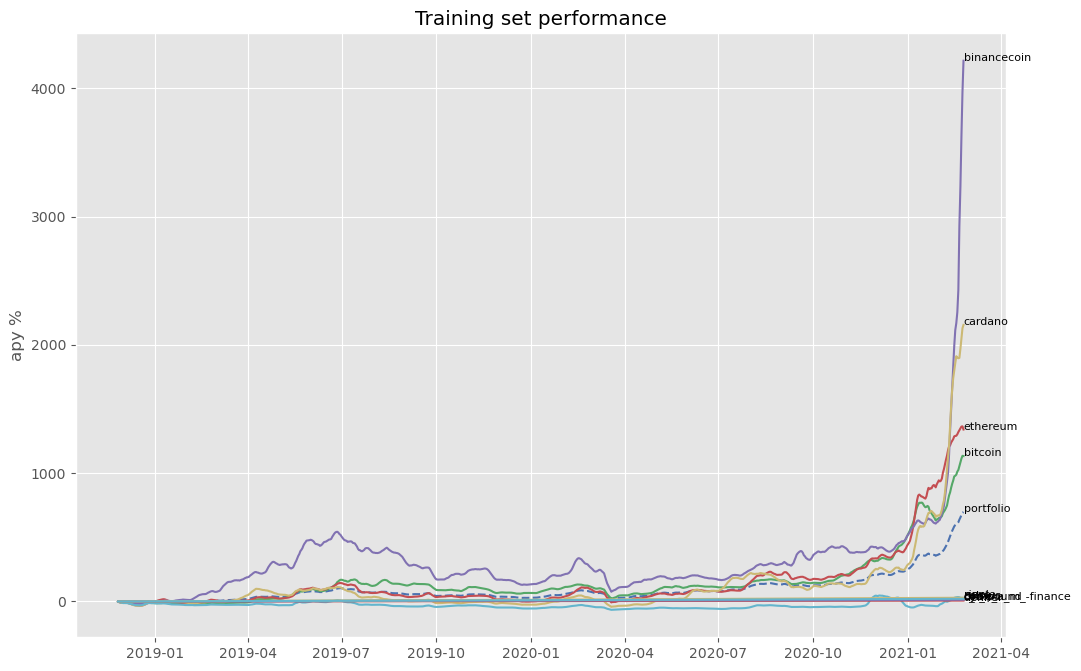

Expected annual return: 127.8%
Annual volatility: 20.6%
Sharpe Ratio: 6.12


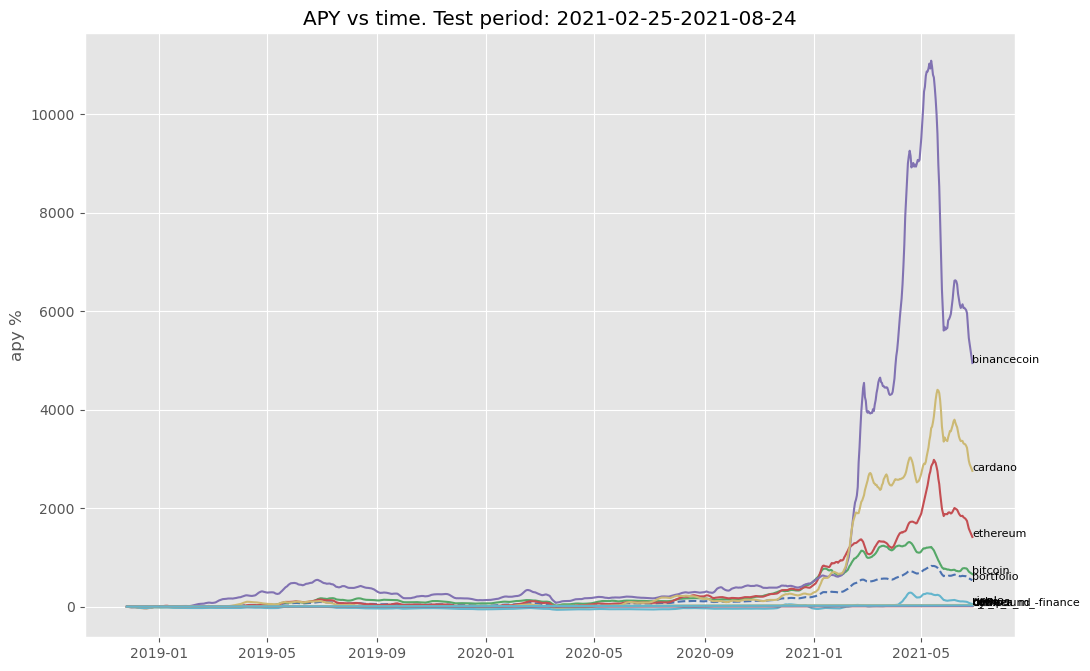

return in the test period 537.3872817146478


In [20]:
# merge coin and lp datasets
assets_df = pd.merge(coin_df[["bitcoin", "ethereum", 
                              "binancecoin", "cardano", "ripple"]], lp_returns_df, 
                     left_index=True, right_index=True, how="inner")
# split data into train and test
train_df = assets_df[assets_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = assets_df[(assets_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (assets_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

def risk4_constraints(ef, train_df):
    for i in range(len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] <= 0.2)
    
    # keep some bitcoin, but not too much
    ef.add_constraint(lambda w: w[0] >= 0.05)
    # keep some ethereum
    ef.add_constraint(lambda w: w[1] >= 0.05)
    # keep ad much btc and eth than alt
    ef.add_constraint(lambda w: w[0]+w[1] >= w[2]+w[3]+w[4])
    for i in range(2, 5):
        ef.add_constraint(lambda w: w[i] <= 0.1)
    


risk4_weights, risk4_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=7, 
                                   target_volatility=0.20, 
                                   constraints_fn=risk4_constraints)

## Risk 5 Portfolio
Lending protocols and top 10 tokens by market cap and 50% annual volatility

In [21]:
# merge coin and lp datasets
# ["bitcoin", "ethereum", "cardano", "monero", "litecoin", "dogecoin",
#                              "chainlink", "ethereum-classic", "tether", "ripple", "neo", "eos", "tron"]]
assets_df = pd.merge(coin_df, lp_returns_df, left_index=True, right_index=True, how="inner")
# split data into train and test
train_df = assets_df[assets_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = assets_df[(assets_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (assets_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]
train_df.head(10)

,bitcoin,ethereum,binancecoin,cardano,ripple,dogecoin,bitcoin-cash,litecoin,chainlink,ethereum-classic,compound,c_r_e_a_m_-finance,definer,dydx,nexo,celsius
2018-11-26,4367.617824,128.724397,5.782891,0.044491,0.423115,0.002340,212.199118,32.888590,0.337625,5.390491,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-11-27,4213.721491,122.872943,5.531542,0.042087,0.405651,0.002297,204.912837,31.878806,0.317673,5.125067,1.000441,1.000461,1.000105,1.000277,1.000311,1.000231
2018-11-28,4125.466214,119.866981,5.404402,0.040847,0.394955,0.002272,198.315611,31.618878,0.309521,4.978176,1.000880,1.000919,1.000210,1.000553,1.000621,1.000462
2018-11-29,4076.008388,117.763179,5.275252,0.039980,0.386622,0.002243,191.613440,31.599106,0.302002,4.864777,1.001317,1.001375,1.000313,1.000830,1.000932,1.000693
2018-11-30,4072.020797,116.568750,5.221063,0.039688,0.380022,0.002219,187.280105,31.863544,0.300289,4.812642,1.001746,1.001825,1.000415,1.001105,1.001243,1.000925
2018-12-01,4019.561459,115.033405,5.142798,0.038946,0.372887,0.002189,182.213441,31.799005,0.299788,4.724031,1.002163,1.002264,1.000516,1.001372,1.001554,1.001156
2018-12-02,4061.523889,115.578095,5.157642,0.039334,0.372270,0.002188,181.083303,32.475593,0.303493,4.725572,1.002568,1.002693,1.000616,1.001633,1.001865,1.001387
2018-12-03,4073.632031,115.352238,5.159675,0.039813,0.370484,0.002185,178.897788,32.797017,0.308496,4.772116,1.002963,1.003114,1.000714,1.001891,1.002176,1.001619
2018-12-04,4083.191418,115.244504,5.178325,0.040208,0.369027,0.002191,175.612480,32.946602,0.306821,4.791843,1.003340,1.003519,1.000809,1.002139,1.002487,1.001850
2018-12-05,4099.015460,115.161214,5.310938,0.040336,0.367632,0.002207,171.579804,32.900789,0.305667,4.766698,1.003695,1.003906,1.000902,1.002377,1.002798,1.002082


mean (yearly) return:
bitcoin               2.059573
ethereum              2.278257
binancecoin           4.342222
cardano               3.002577
ripple                0.111870
dogecoin              3.041950
bitcoin-cash          0.667742
litecoin              1.332577
chainlink             6.607108
ethereum-classic      0.556015
compound              0.052304
c_r_e_a_m_-finance    0.075553
definer               0.029790
dydx                  0.058097
nexo                  0.120000
celsius               0.088000
dtype: float64

---portfolio weights---
OrderedDict([('bitcoin', 0.15),
             ('ethereum', 0.15),
             ('binancecoin', 0.08),
             ('cardano', 0.06),
             ('ripple', 0.0),
             ('dogecoin', 0.08),
             ('bitcoin-cash', 0.0),
             ('litecoin', 0.0),
             ('chainlink', 0.08),
             ('ethereum-classic', 0.0),
             ('compound', 0.0),
             ('c_r_e_a_m_-finance', 0.0),
             ('definer', 0.0),

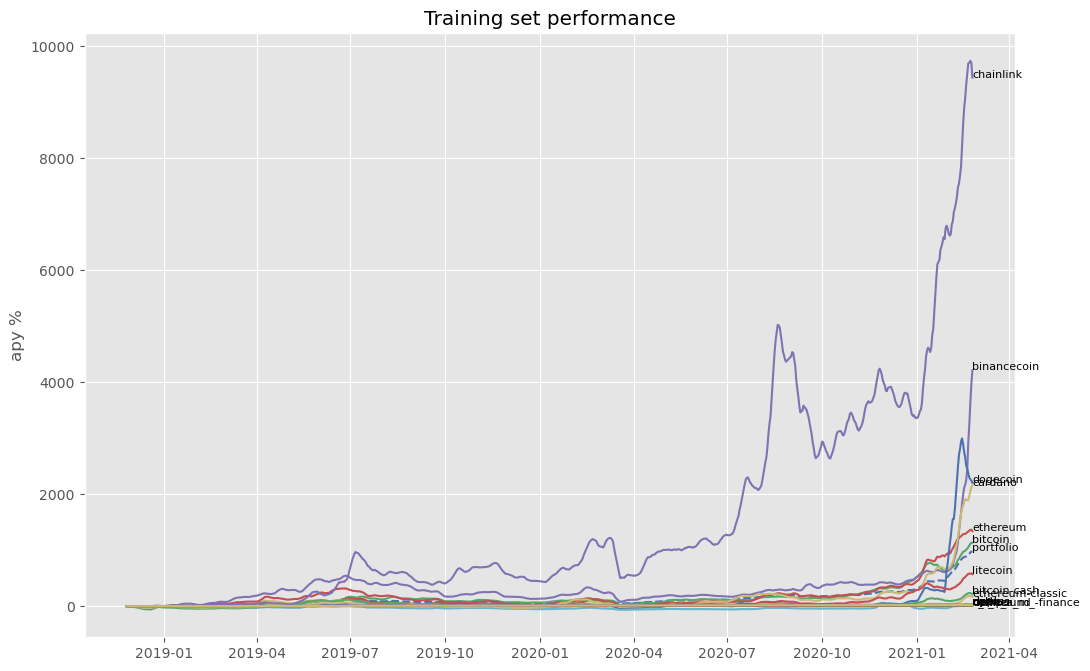

Expected annual return: 163.4%
Annual volatility: 20.3%
Sharpe Ratio: 7.96


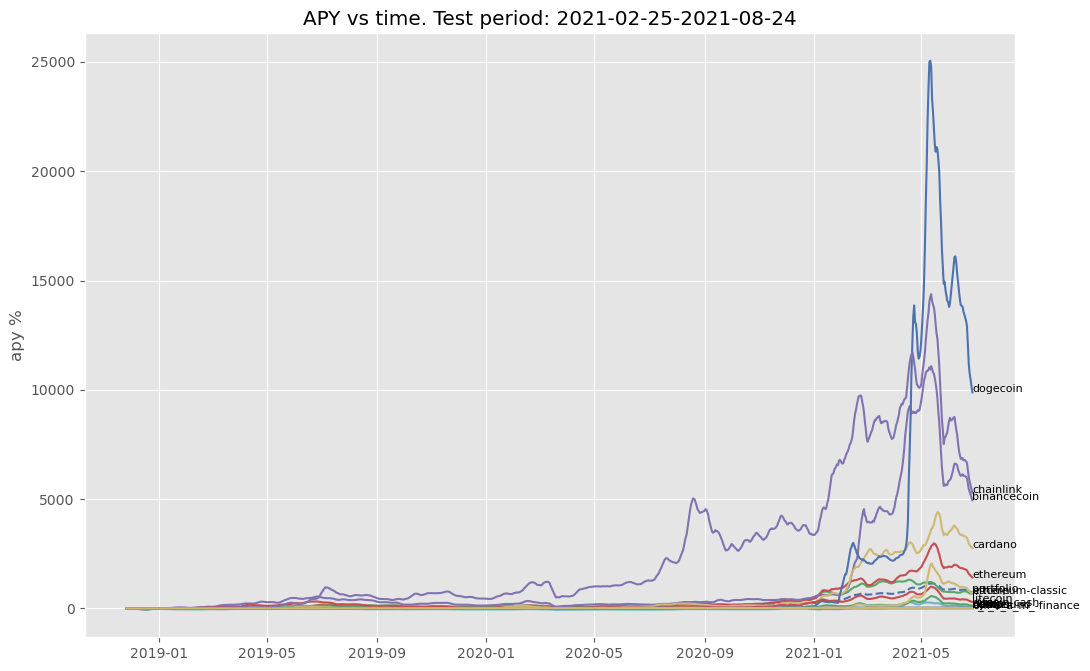

return in the test period 734.1499351251642


In [22]:
# merge coin and lp datasets
assets_df = pd.merge(coin_df, lp_returns_df, left_index=True, right_index=True, how="inner")
# split data into train and test
train_df = assets_df[assets_df.index < datetime.strptime(split_date, '%Y-%m-%d').date()]
test_df = assets_df[(assets_df.index >= datetime.strptime(test_start, '%Y-%m-%d').date()) 
                        & (assets_df.index <= datetime.strptime(test_end, '%Y-%m-%d').date())]

def risk5_constraints(ef, train_df):
    for i in range(2, len(train_df.columns)-6):
        ef.add_constraint(lambda w: w[i] <= 0.08)
    
    for i in range(len(train_df.columns)-6, len(train_df.columns)):
        ef.add_constraint(lambda w: w[i] <= 0.2)
    
    # keep some bitcoin, but not too much
    ef.add_constraint(lambda w: w[0] >= 0.10)
    ef.add_constraint(lambda w: w[0] <= 0.15)
    # keep some ethereum
    ef.add_constraint(lambda w: w[1] >= 0.10)
    ef.add_constraint(lambda w: w[1] <= 0.15)
    # keep ad much btc and eth than alt
    ef.add_constraint(lambda w: w[0]+w[1] >= sum(w[2:-6]))
    
risk5_weights, risk5_roi = optimize_portfolio(train_df, test_df, 
                                   rebalance_period=7, 
                                   target_volatility=0.25, 
                                   constraints_fn=risk5_constraints)

In [23]:
roi_df = pd.DataFrame({"risk1_roi" : risk1_roi,
                      "risk2_roi" : risk2_roi,
                      "risk3_roi" : risk3_roi,
                      "risk4_roi" : risk4_roi,
                      "risk5_roi" : risk5_roi})
roi_df.index = test_df.index
roi_df.to_csv("../data/portfolios/roi_2021-07-08.csv")
assets_df.to_csv("../data/clean_data/asset_prices_2021-07-08.csv")
lend_rates_df.to_csv("../data/clean_data/lend_rates_2021-07-08.csv")

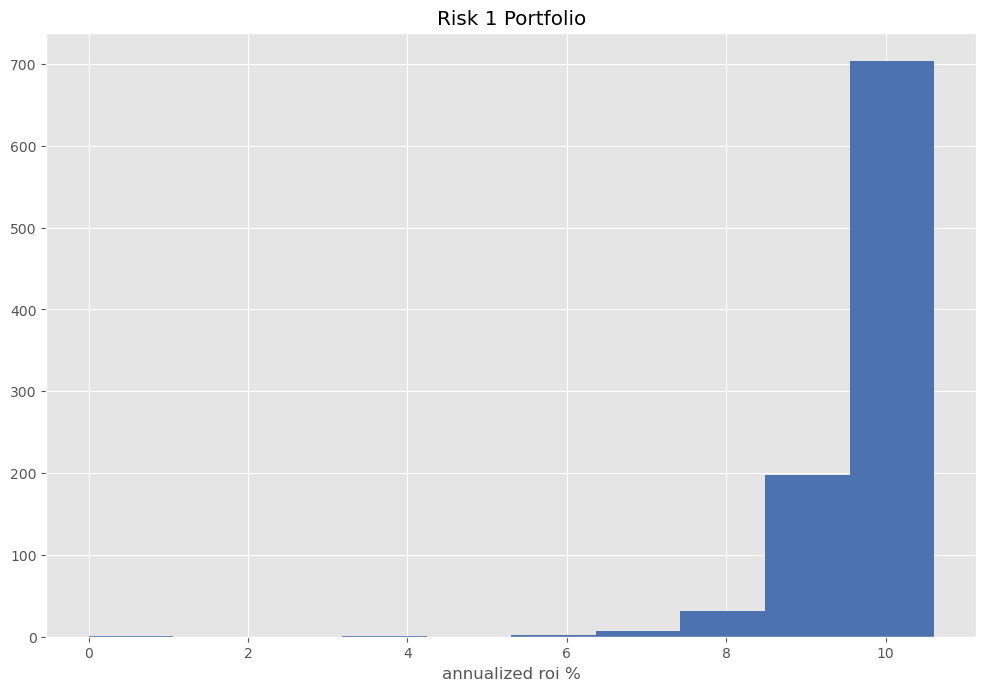

<Figure size 600x400 with 0 Axes>

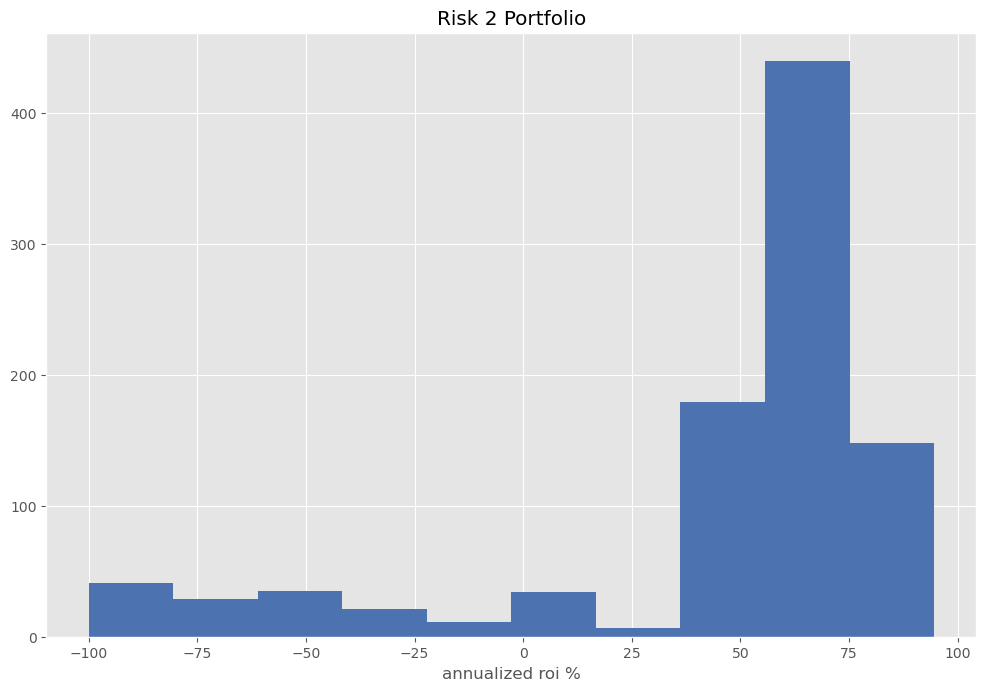

<Figure size 600x400 with 0 Axes>

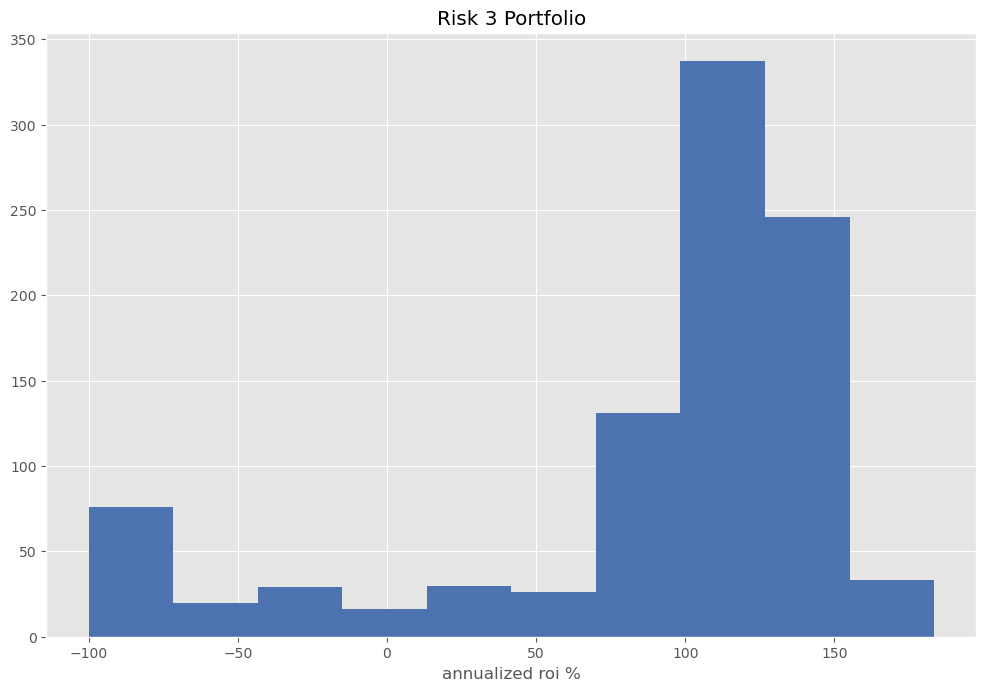

<Figure size 600x400 with 0 Axes>

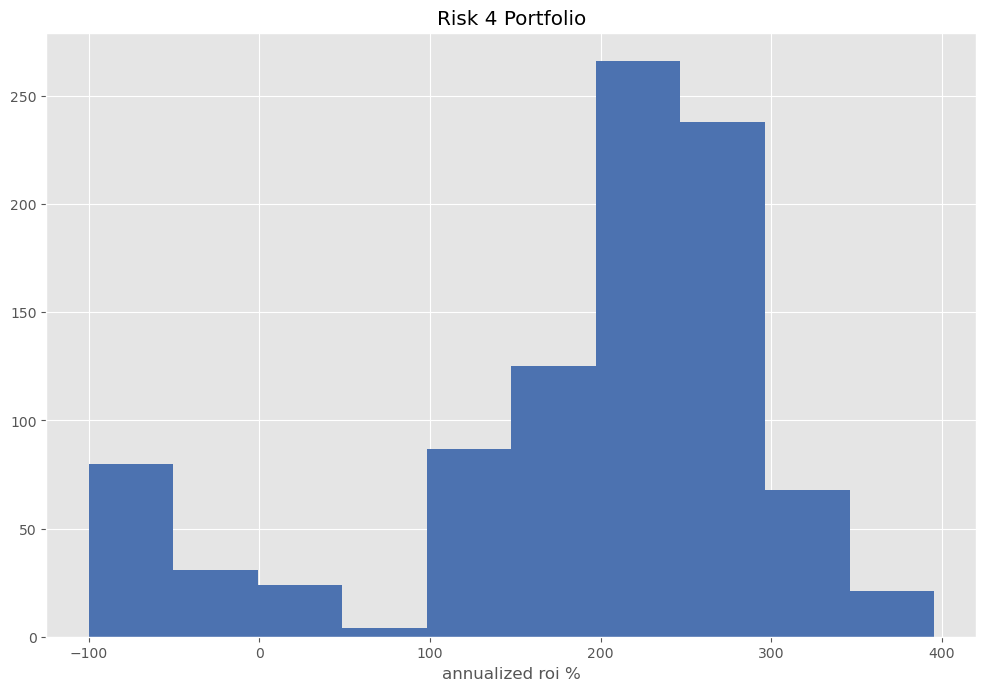

<Figure size 600x400 with 0 Axes>

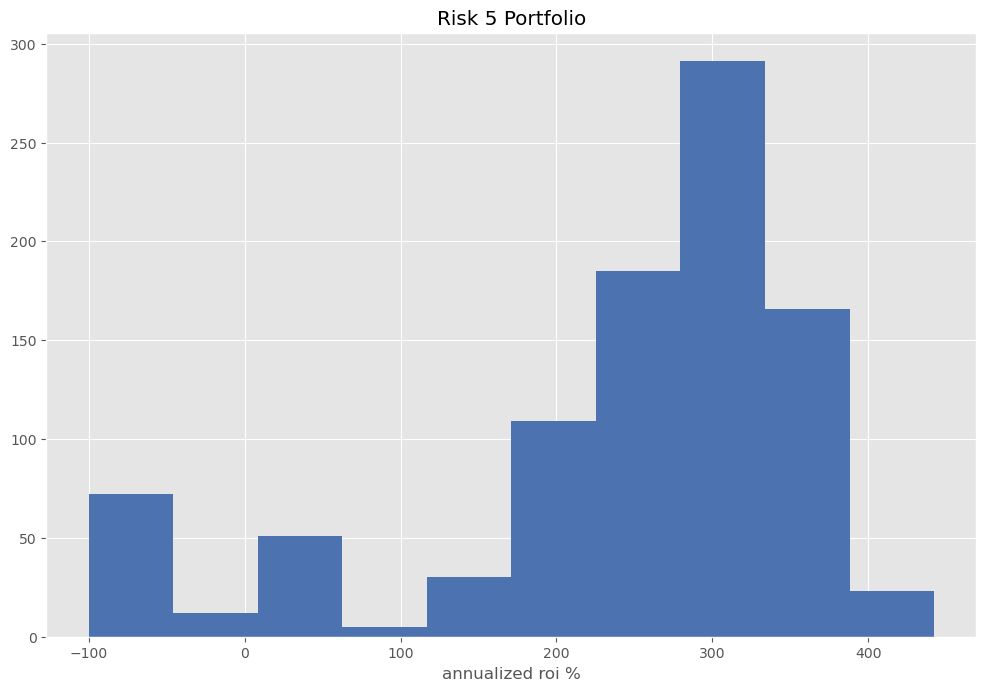

<Figure size 600x400 with 0 Axes>

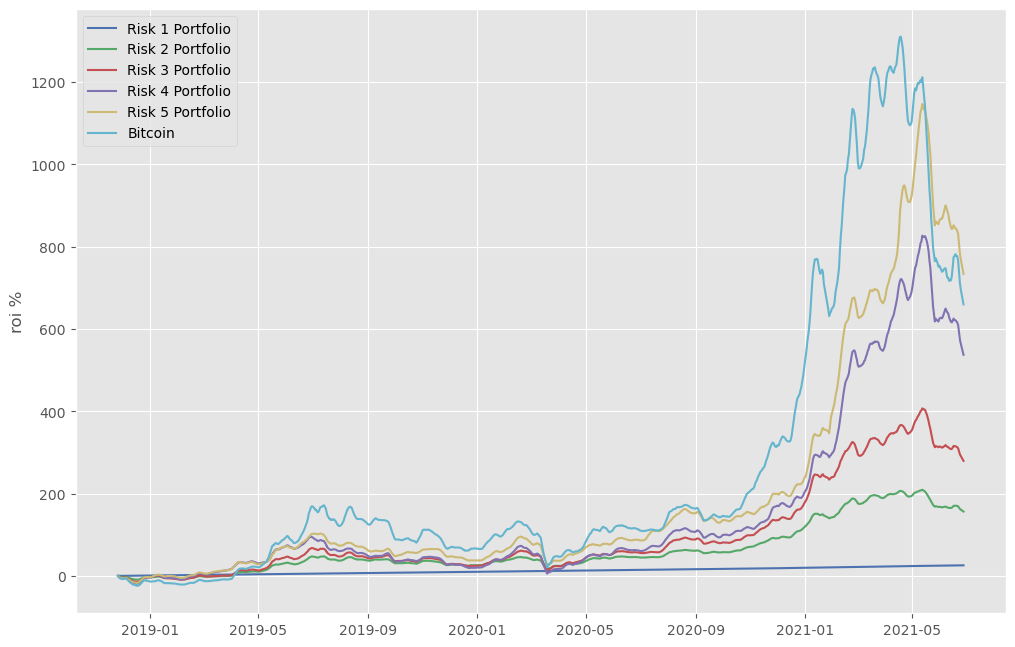

In [29]:
def barplot_roi(roi, dates, title):
    assert len(roi) == len(dates)
    y = []
    for i, r in enumerate(roi):
        end_investment_value = (100 + roi[-1])
        day_i_investment_value = (100 + r)
        investment_return = 100*(end_investment_value / day_i_investment_value - 1)
        annualized_return = max(-100, 365/(len(roi)-i)*investment_return)
        y.append(annualized_return)
#     plt.bar(dates, y, color ='C1', width=0.25, alpha=0.8)
#     print(y)
    plt.hist(y)
    plt.xlabel("annualized roi %")
    plt.title(f"{title} Portfolio")
    plt.figure(figsize=(6,4), dpi= 100)
    plt.show()

barplot_roi(risk1_roi, test_df.index, title="Risk 1")
barplot_roi(risk2_roi, test_df.index, title="Risk 2")
barplot_roi(risk3_roi, test_df.index, title="Risk 3")
barplot_roi(risk4_roi, test_df.index, title="Risk 4")
barplot_roi(risk5_roi, test_df.index, title="Risk 5")

plt.plot(test_df.index, risk1_roi, label="Risk 1 Portfolio")
plt.plot(test_df.index, risk2_roi, label="Risk 2 Portfolio")
plt.plot(test_df.index, risk3_roi, label="Risk 3 Portfolio")
plt.plot(test_df.index, risk4_roi, label="Risk 4 Portfolio")
plt.plot(test_df.index, risk5_roi, label="Risk 5 Portfolio")
plt.plot(test_df.index, 100*(test_df["bitcoin"]/test_df["bitcoin"][0]-1), label="Bitcoin")
plt.ylabel("roi %")
plt.legend()
plt.show()